# Part I: Introduction to Modeling in Jax


Learning objectives:
- Build a forward model using Jax
- Build a likelihood using TensorFlow Probability
- Retrieve maximum likelihood solution by optimization

## What is Jax?

## Extracting the data

In [19]:
%pylab inline
import quarks2cosmos.datasets
import tensorflow_datasets as tfds

Populating the interactive namespace from numpy and matplotlib


In [16]:
dset_cosmos = tfds.load("Cosmos/23.5", split=tfds.Split.TRAIN)
dset_cosmos = dset_cosmos.as_numpy_iterator()

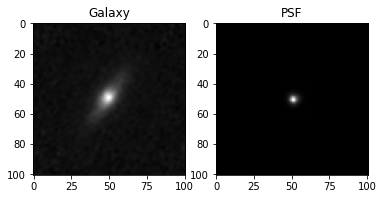

In [462]:
cosmos = next(dset_cosmos)

figure()
subplot(121)
imshow(cosmos['image'],cmap='gray')
title('Galaxy')
subplot(122)
imshow(cosmos['psf'],cmap='gray')
title('PSF');

In [504]:
dset_hsc = tfds.load("HSC",         split=tfds.Split.TRAIN)
dset_hsc = dset_hsc.as_numpy_iterator()

Text(0.5, 1.0, 'Variance plane')

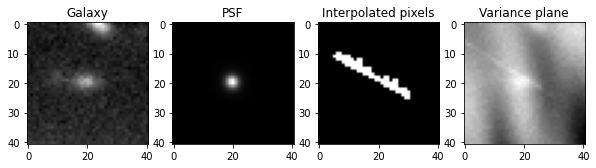

In [513]:
hsc = next(dset_hsc)

figure(figsize=[10,2.5])
subplot(141)
imshow(hsc['image'],cmap='gray')
title('Galaxy')
subplot(142)
imshow(hsc['psf'],cmap='gray')
title('PSF')
subplot(143)
imshow(hsc['mask'] == 44,cmap='gray')
title('Interpolated pixels')
subplot(144)
imshow(hsc['variance'],cmap='gray')
title('Variance plane')

## Building a forward model

In [514]:
import jax
import jax.numpy as jnp
from quarks2cosmos import galjax as gj

In [515]:
def simulate_hsc(x, in_psf, out_psf):
    y = gj.deconvolve(x, in_psf)
    y = gj.kresample(y, 0.03, 0.168, 41)
    y = gj.convolve(y,  out_psf)
    return 2.587*y # Conversion factor for the flux

In [516]:
im = simulate_hsc(cosmos['image'], cosmos['psf'], hsc['psf'])

Text(0.5, 1.0, 'As seen from Subaru')

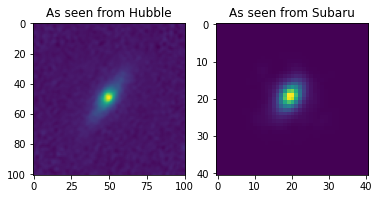

In [517]:
subplot(121)
imshow(cosmos['image'])
title('As seen from Hubble')
subplot(122)
imshow(im)
title('As seen from Subaru')

In [518]:
# Now, let's model the noise in the target image
from tensorflow_probability.substrates import jax as tfp
tfd = tfp.distributions
tfb = tfp.bijectors

In [519]:
likelihood = tfd.Independent(tfd.Normal(simulate_hsc(cosmos['image'], cosmos['psf'], hsc['psf']),
                                                     jnp.sqrt(hsc['variance'])), 
                             reinterpreted_batch_ndims=2)

In [520]:
im_noise = likelihood.sample(seed=jax.random.PRNGKey(1))

Text(0.5, 1.0, 'As seen from Subaru + Noise')

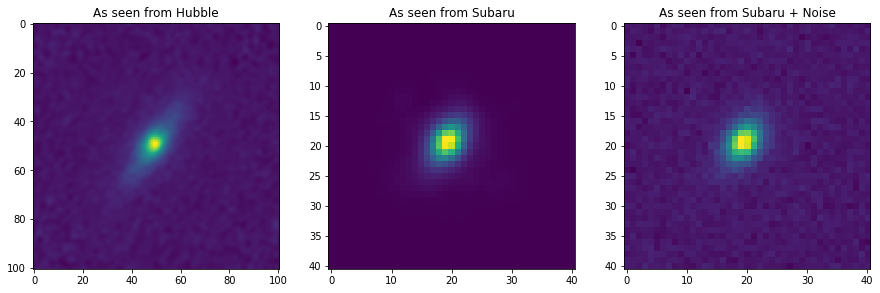

In [521]:
figure(figsize=[15,5])
subplot(131)
imshow(cosmos['image'])
title('As seen from Hubble')
subplot(132)
imshow(im)
title('As seen from Subaru')
subplot(133)
imshow(im_noise)
title('As seen from Subaru + Noise')

## Solving the inverse problem with classical method

In [522]:
# We will use this galaxy as are reference here
obs = im_noise

In [523]:
def log_prob(x):
    likelihood = tfd.Independent(tfd.Normal(simulate_hsc(x, cosmos['psf'], hsc['psf']),
                                                     jnp.sqrt(hsc['variance'])), 
                             reinterpreted_batch_ndims=2)
    return likelihood.log_prob(obs)

In [524]:
log_prob(cosmos['image'])

DeviceArray(2639.359, dtype=float32)

In [525]:
# First try, let's try to find a maximum likelihood solution
import optax
optimizer = optax.adam(0.01)

In [526]:
# Create a parameter
x = jnp.zeros([101, 101])
opt_state = optimizer.init(x)

In [527]:
# write an update function
@jax.jit
def update(x, opt_state):
    logp, grads = jax.value_and_grad(log_prob)(x)
    updates, opt_state = optimizer.update(-grads, opt_state)
    x = optax.apply_updates(x, updates)
    return logp, x, opt_state

In [528]:
losses = []

In [529]:
for i in range(100):
    logp, x, opt_state = update(x, opt_state)
    losses.append(logp)

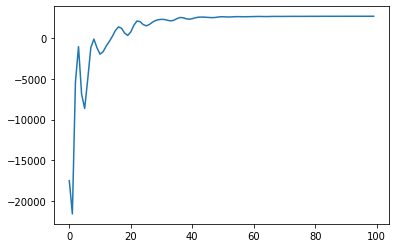

In [530]:
plot(losses)

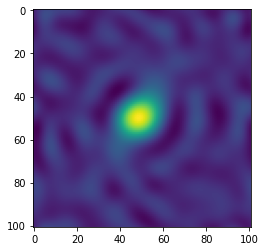

In [531]:
imshow(x)

<Figure size 432x288 with 0 Axes>

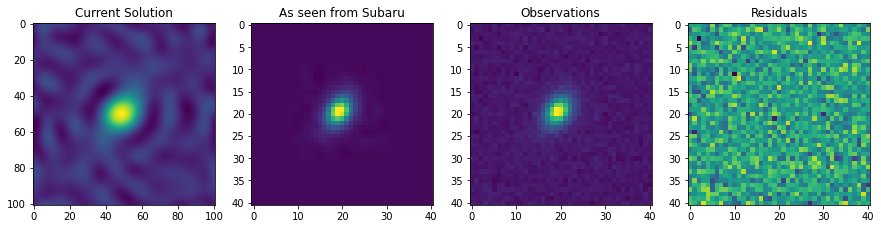

In [532]:
figure()
figure(figsize=[15,5])
subplot(141)
imshow(x)
title('Current Solution')
subplot(142)
imshow(simulate_hsc(x, cosmos['psf'], hsc['psf']))
title('As seen from Subaru')
subplot(143)
imshow(obs)
title('Observations')
subplot(144)
imshow(obs - simulate_hsc(x, cosmos['psf'], hsc['psf']))
title('Residuals');

## Adding the mask and proximal regularisation 

In [533]:
def log_prob(x):
    likelihood = tfd.Independent(tfd.Normal(simulate_hsc(x, cosmos['psf'], hsc['psf']),
                                            jnp.sqrt(hsc['variance'] + (hsc['mask'] == 44)*1e3)), 
                             reinterpreted_batch_ndims=2)
    return likelihood.log_prob(obs*(hsc['mask'] != 44))

In [534]:
def prox_sdss_symmetry(X):
    """SDSS/HSC symmetry operator
    This function uses the *minimum* of the two
    symmetric pixels in the update.
    """
    Xs = jnp.fliplr(jnp.flipud(X))
    return jnp.min(jnp.stack([X, Xs]), axis=0)

In [564]:
optimizer = optax.adam(0.001)

In [565]:
# Create a parameter
x = jnp.zeros([101, 101])
opt_state = optimizer.init(x)

In [571]:
@jax.jit
def update(x, opt_state):
    logp, grads = jax.value_and_grad(lambda x: log_prob(x))(x)
    updates, opt_state = optimizer.update(-grads, opt_state)
    
    # Apply gradient descent
    x = optax.apply_updates(x, updates)
    
    # Apply proximal constraints
    x = jnp.abs(x)
    # x = prox_sdss_symmetry(x)
    
    return logp, x, opt_state

In [572]:
losses = []

In [573]:
for i in range(1000):
    logp, x, opt_state = update(x, opt_state)
    losses.append(logp)

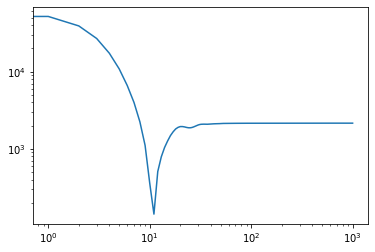

In [577]:
loglog(abs(np.array(losses)))

<Figure size 432x288 with 0 Axes>

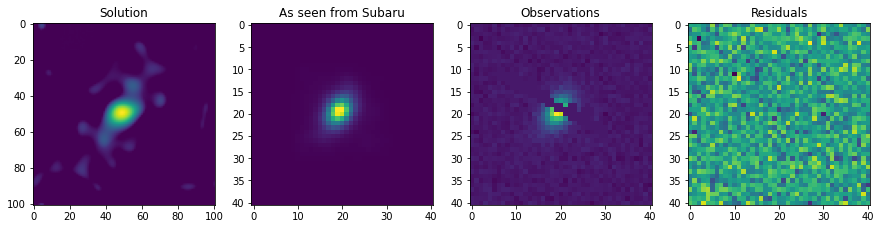

In [578]:
figure()
figure(figsize=[15,5])
subplot(141)
imshow(x)
title('Solution')
subplot(142)
imshow(simulate_hsc(x, cosmos['psf'], hsc['psf']))
title('As seen from Subaru')
subplot(143)
imshow(obs*(hsc['mask'] != 44))
title('Observations')
subplot(144)
imshow((obs - simulate_hsc(x, cosmos['psf'], hsc['psf'])))
title('Residuals');

## Try to use a Deep Neural Network to solve the inverse problem

In [648]:
import tensorflow as tf
import haiku as hk

In [649]:
class Unet(hk.Module):
    def __call__(self, x):
        
        x = hk.Conv2D(16, kernel_shape=3)(x)
        l1 = jax.nn.leaky_relu(x)
        x = hk.avg_pool(l1, window_shape=3, strides=2, padding='SAME')

        x = hk.Conv2D(32, kernel_shape=3)(x)
        l2 = jax.nn.leaky_relu(x)
        x = hk.avg_pool(l2,  window_shape=3, strides=2, padding='SAME')

        x = hk.Conv2D(64, kernel_shape=3)(x)
        l3 = jax.nn.leaky_relu(x)
        x = hk.avg_pool(l3, window_shape=3, strides=2, padding='SAME')

        x = hk.Conv2D(128, kernel_shape=3)(x)
        x = jax.nn.leaky_relu(x)
        
        x = hk.Conv2DTranspose(64, kernel_shape=3, stride=2)(x)
        x = jax.nn.leaky_relu(x)
        x = jnp.concatenate([x, l3], axis=-1)
        
        x = hk.Conv2DTranspose(32, kernel_shape=3, stride=2)(x)
        x = jax.nn.leaky_relu(x)
        x = jnp.concatenate([x, l2], axis=-1)

        x = hk.Conv2DTranspose(16, kernel_shape=3, stride=2)(x)
        x = jax.nn.leaky_relu(x)
        x = jnp.concatenate([x, l1], axis=-1)

        x = hk.Conv2D(1, kernel_shape=3)(x)
        
        return x

In [762]:
model = hk.transform(lambda x: Unet()(x))

In [763]:
params = model.init(jax.random.PRNGKey(0), jnp.zeros([1,128,128,1]))

In [799]:
def augment_cosmos(example):
    """
    """
    x = example['image'][...,tf.newaxis]
    x = tf.image.flip_left_right(x)
    x = tf.image.flip_up_down(x)
    return {'image':x[...,0], 'psf':example['psf']}

In [800]:
# Create a dataset
dset_cosmos = tfds.load("Cosmos/23.5",
                        split=tfds.Split.TRAIN)
dset_cosmos = dset_cosmos.cache()
dset_cosmos = dset_cosmos.repeat()
dset_cosmos = dset_cosmos.map(augment_cosmos)
dset_cosmos = dset_cosmos.shuffle(40000)

dset_hsc = tfds.load("HSC",
                     split=tfds.Split.TRAIN)
dset_hsc = dset_hsc.cache()
dset_hsc = dset_hsc.repeat()
dset_hsc = dset_hsc.shuffle(10000)

combined_dset = dset_hsc.zip((dset_cosmos, dset_hsc))

combined_dset = combined_dset.batch(64)

In [801]:
it  = combined_dset.as_numpy_iterator()

In [835]:
def loss_fn(params, rng, batch, return_images=False):
    # Create mock observations
    cosmos, hsc = batch
    
    def prep_data(cosmos, hsc):
        """ Prepares data for the neural network
        """        
        obs = tfd.Independent(tfd.Normal(jax.vmap(simulate_hsc)(cosmos['image'], cosmos['psf'], hsc['psf']),
                         jnp.sqrt(hsc['variance'])),
                             reinterpreted_batch_ndims=2).sample(seed=rng)

        # Rescale obs to same pixel scale to make the life of the network easier
        x = jax.image.scale_and_translate(obs, [len(obs), 128, 128], [1,2], 
                                            jnp.array([5.6, 5.6]), 
                                            jnp.array([128/2 - 41/2*5.6 ,128/2 - 41/2*5.6 ]), 
                                            jax.image.ResizeMethod.CUBIC)

        # Resize input and outputs for the network
        im  = jnp.pad(cosmos['image'], [[0,0], [14,13] , [14,13]])

        # Adding channel dimension
        im = jnp.expand_dims(im, -1)
        x = jnp.expand_dims(x, -1)
        return im, x, obs

    im, x, obs = prep_data(cosmos, hsc )
    
    # Apply neural network
    rec = model.apply(params, None, x)
    
    loss = jnp.mean( jnp.sum( (rec - im)**2, axis=[1, 2, 3]))
    if return_images:
        return im, obs, x, rec, loss
    else:
        return loss

In [836]:
optimizer = optax.adam(0.0002)
opt_state = optimizer.init(params)
rng_seq = hk.PRNGSequence(12)
losses = []

In [837]:
@jax.jit
def update(params, rng, opt_state):
    loss, grads = jax.value_and_grad(loss_fn)(params, rng, batch)
    updates, opt_state = optimizer.update(grads, opt_state)
    # Apply gradient descent
    params = optax.apply_updates(params, updates)
    return loss, params, opt_state

In [ ]:
for i in range(10000):
    batch = next(it)
    loss, params, opt_state = update(params, next(rng_seq), opt_state)
    losses.append(loss)

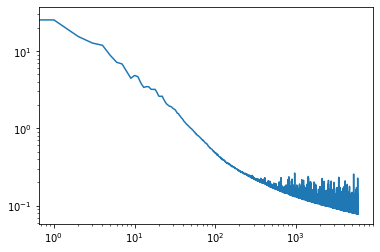

In [846]:
loglog(losses)

In [847]:
# Create a dataset
dset_cosmos_test = tfds.load("Cosmos/23.5",
                        split=tfds.Split.TEST)
dset_cosmos_test = dset_cosmos_test.cache()
dset_cosmos_test = dset_cosmos_test.repeat()

dset_hsc = tfds.load("HSC",
                     split=tfds.Split.TRAIN)
dset_hsc = dset_hsc.cache()
dset_hsc = dset_hsc.repeat()
dset_hsc = dset_hsc.shuffle(10000)

combined_dset_test = dset_hsc.zip((dset_cosmos_test , dset_hsc))

combined_dset_test = combined_dset_test.batch(64)

In [848]:
it_test  = combined_dset_test.as_numpy_iterator()

In [851]:
batch = next(it_test)
im, obs, y, rec, loss = loss_fn(params, next(rng_seq), batch, return_images=True)
cosmos, hsc = batch

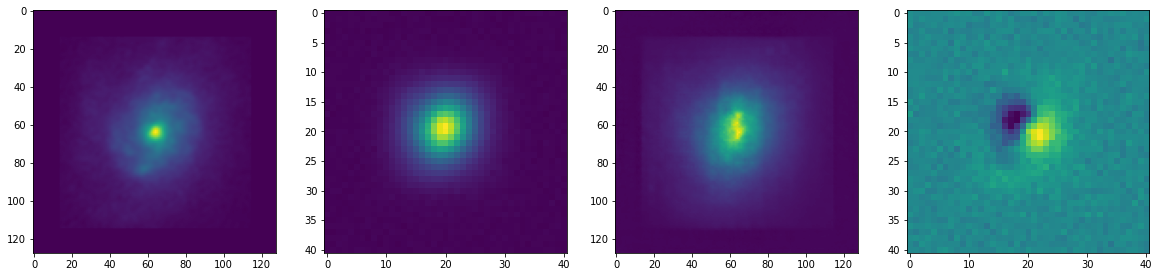

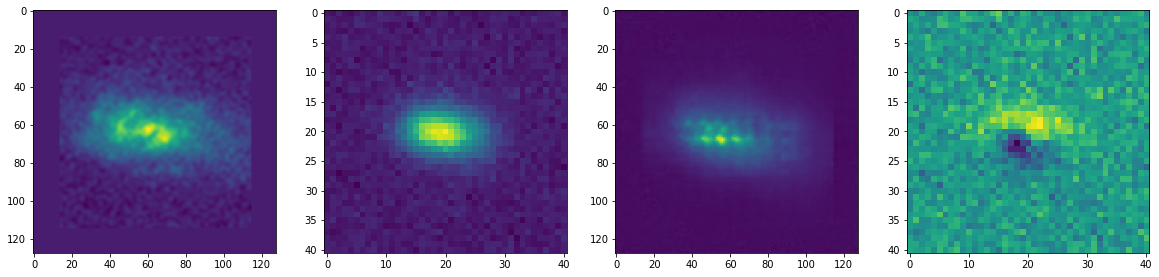

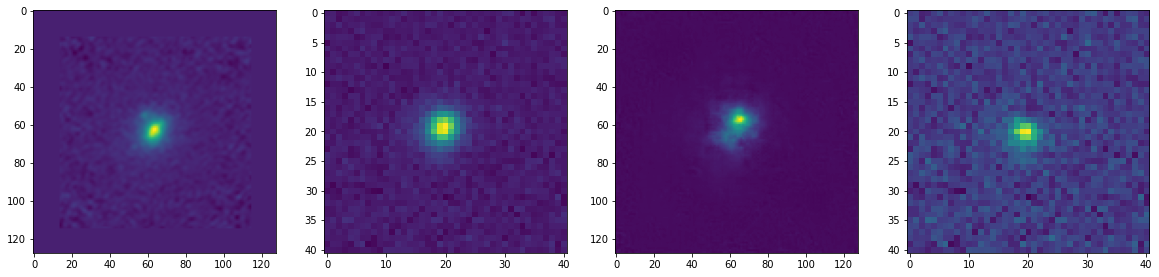

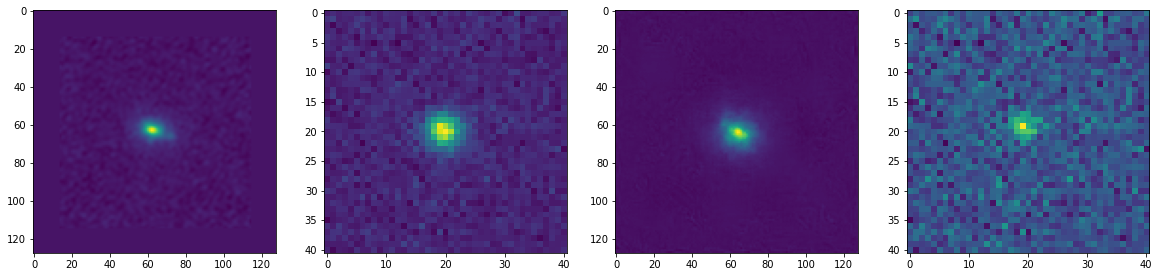

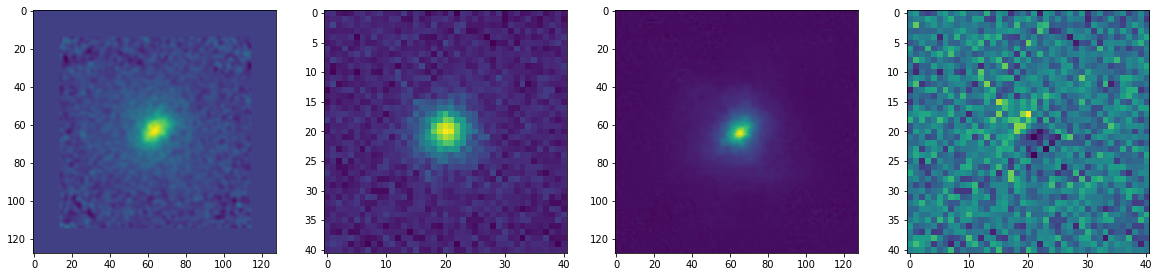

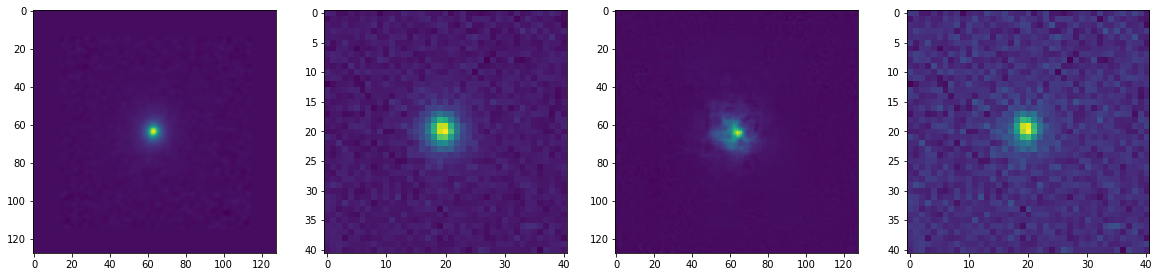

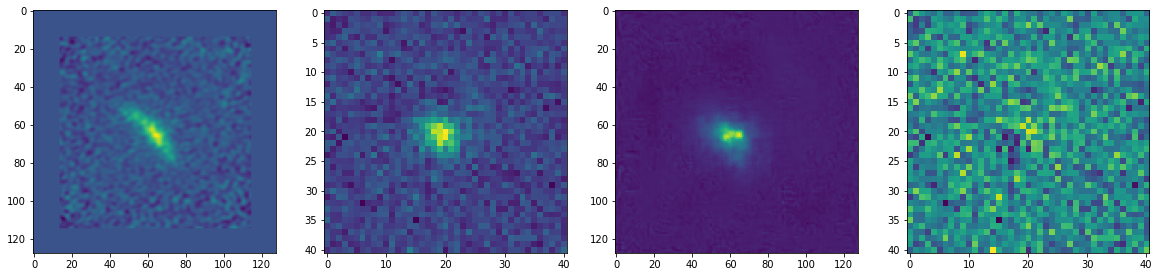

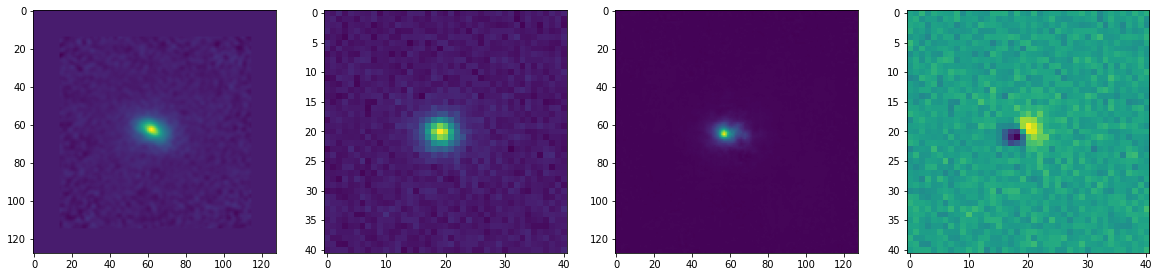

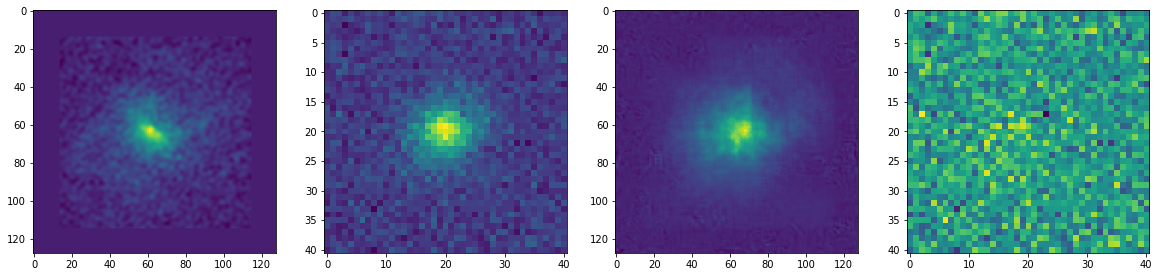

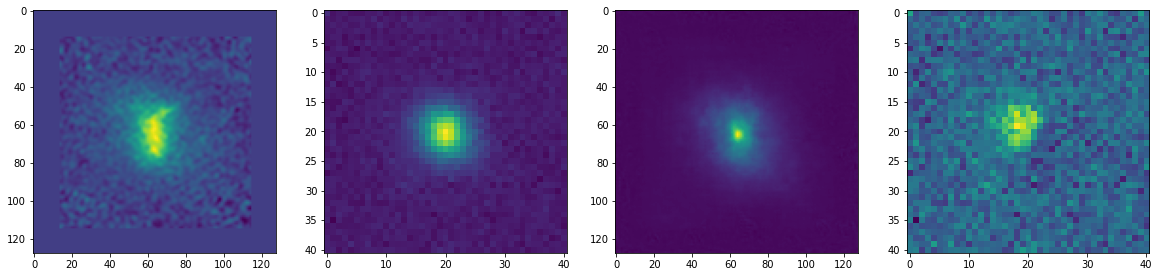

In [852]:
for i in range(10):
    figure(figsize=[20,5])
    subplot(141)
    imshow(im[i])
    subplot(142)
    imshow(obs[i])
    subplot(143)
    imshow(rec[i])
    subplot(144)
    # Removing the padding
    x = rec[i][14:-13:,14:-13:,0]
    x = simulate_hsc(x, cosmos['psf'][i], hsc['psf'][i])
    # Show residuals on observations
    imshow(obs[i] - x)